# Fit

author: steeve laquitaine

Fit the standard Bayesian model to psychophysics circular estimates and use it make predictions.

## Setup

In [3]:
# go to the project's root path
import os
os.chdir("..")

In [22]:
# import dependencies
from bsfit.nodes.models.bayes import StandardBayes
from bsfit.nodes.dataEng import (
    simulate_dataset,
)
from bsfit.nodes.models.utils import (
    get_data, get_data_stats, get_prediction_stats
)
from bsfit.nodes.viz.prediction import plot_mean
from matplotlib import pyplot as plt
from bsfit.nodes.cirpy.viz import plot_von_mises
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set parameters

In [9]:
# set the parameters
SUBJECT = "sub01"
PRIOR_SHAPE = "vonMisesPrior"
PRIOR_MODE = 225
OBJ_FUN = "maxLLH"
READOUT = "map"
PRIOR_NOISE = [80, 40]      # e.g., prior's std
STIM_NOISE = [0.33, 0.66, 1.0]
INIT_P = {
    "k_llh": [2.7, 10.7, 33],
    "k_prior": [2.7, 33],
    "prior_tail": [0],
    "p_rand": [0],
    "k_m": [2000],
}
CENTERING = True

## Simulate dataset

In [10]:
# simulate a training dataset
train_dataset = simulate_dataset(
    stim_noise=STIM_NOISE,
    prior_mode=PRIOR_MODE,
    prior_noise=PRIOR_NOISE,
    prior_shape=PRIOR_SHAPE,
)

# use the train dataset as test to show 
# best predictions
test_dataset = get_data(train_dataset)

## Train model and predict

In [11]:
# instantiate the model
model = StandardBayes(
    initial_params=INIT_P,
    prior_shape=PRIOR_SHAPE, 
    prior_mode=PRIOR_MODE, 
    readout=READOUT
    )

# train the model
model = model.fit(dataset=train_dataset)

Training the model ...

-logl:50265.93, aic:100549.87, kl:[ 2.7 10.7 33. ], kp:[ 2.7 33. ], kc:[1.], pt:0.00, pr:0.00, km:2000.00
-logl:63349.73, aic:126717.45, kl:[ 2.835 10.7   33.   ], kp:[ 2.7 33. ], kc:[1.], pt:0.00, pr:0.00, km:2000.00
-logl:50284.86, aic:100587.73, kl:[ 2.7   11.235 33.   ], kp:[ 2.7 33. ], kc:[1.], pt:0.00, pr:0.00, km:2000.00
-logl:64023.04, aic:128064.09, kl:[ 2.7  10.7  34.65], kp:[ 2.7 33. ], kc:[1.], pt:0.00, pr:0.00, km:2000.00
-logl:67066.68, aic:134151.37, kl:[ 2.7 10.7 33. ], kp:[ 2.835 33.   ], kc:[1.], pt:0.00, pr:0.00, km:2000.00
-logl:69232.46, aic:138482.91, kl:[ 2.7 10.7 33. ], kp:[ 2.7  34.65], kc:[1.], pt:0.00, pr:0.00, km:2000.00
-logl:50265.93, aic:100549.87, kl:[ 2.7 10.7 33. ], kp:[ 2.7 33. ], kc:[1.05], pt:0.00, pr:0.00, km:2000.00
-logl:50265.93, aic:100549.87, kl:[ 2.7 10.7 33. ], kp:[ 2.7 33. ], kc:[1.], pt:0.00, pr:0.00, km:2000.00
-logl:3871.50, aic:7761.00, kl:[ 2.7 10.7 33. ], kp:[ 2.7 33. ], kc:[1.], pt:0.00, pr:0.00, km:2000.00
-l

The fitted model's attributes are:

In [12]:
# list the model's attributes
model.get_attributes()

['prior_shape', 'prior_mode', 'readout', 'best_fit_p', 'neglogl', 'params']

The model's fixed parameters are:

In [13]:
# look at the model ...
model.params["model"]["fixed_params"]

{'prior_shape': 'vonMisesPrior', 'prior_mode': 225, 'readout': 'map'}

The model's learnt parameters are:

In [14]:
# and at ... its best fit parameters
model.best_fit_p.tolist()

[2.7, 10.7, 33.0, 2.7, 33.0, 1.0, 0.0, 0.00025, 2000.0]

In [16]:
# get predictions
output = model.predict(test_dataset, granularity="mean")
print("predictions data:", list(output.keys()))

Calculating predictions ...

-logl:3871.50, aic:7761.00, kl:[ 2.7 10.7 33. ], kp:[ 2.7 33. ], kc:[1.], pt:0.00, pr:0.00, km:2000.00
predictions data: ['PestimateGivenModel', 'map', 'conditions', 'prediction_mean', 'prediction_std']


## Plot stats for data & predictions

We calculate the data and prediction mean and standard deviations.

In [17]:
# get data stats
estimate = test_dataset[1]
output = get_data_stats(estimate, output)

# get prediction stats
output = get_prediction_stats(output)

We plot the stats.

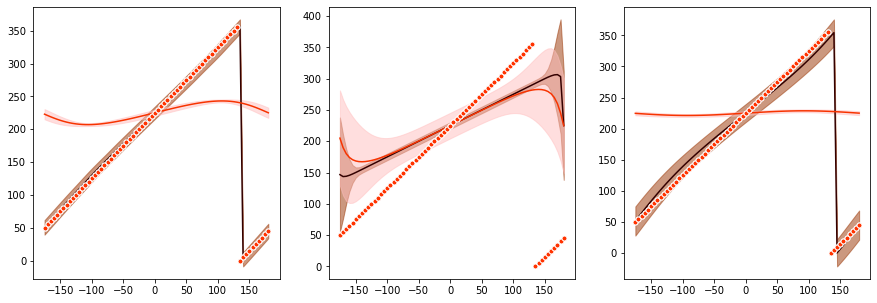

In [18]:
# plot
plt.figure(figsize=(15,5))
plot_mean(
    output["data_mean"],
    output["data_std"],
    output["prediction_mean"],
    output["prediction_std"],
    output["conditions"],
    prior_mode=PRIOR_MODE,
    centering=CENTERING,
)

## Look at the model's trained parameters

### Measure the strengths of the priors

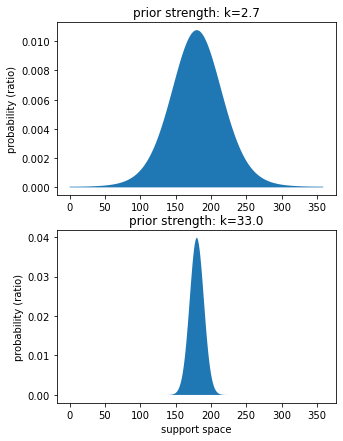

In [38]:
# set support space and get strength
prior_strengths = model.best_fit_p.tolist()[3:5]
support_space = np.arange(0,360,1)
n_strengths = len(prior_strengths)

plt.figure(figsize=(5,7))
for ix, k_p in enumerate(prior_strengths):

    # set panel
    plt.subplot(n_strengths,1,ix+1)

    # plot prior
    plot_von_mises(support_space, k_p)

    # legend
    plt.title(f"prior strength: k={k_p}")
    plt.ylabel("probability (ratio)")
    if ix == len(prior_strengths)-1:
        plt.xlabel("support space")
    

### Measure the strengths of the sensory stimulus (llh)

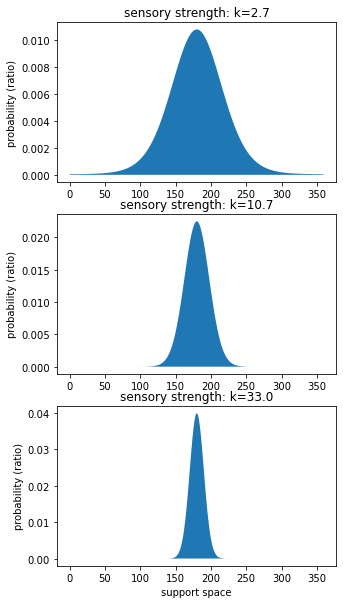

In [39]:
# get strength
sensory_strength = model.best_fit_p.tolist()[0:3]
n_strengths = len(sensory_strength)

plt.figure(figsize=(5,10))
for ix, k_s in enumerate(sensory_strength):

    # set panel
    plt.subplot(n_strengths,1,ix+1)

    # plot prior
    plot_von_mises(support_space, k_s)

    # legend
    plt.title(f"sensory strength: k={k_s}")
    plt.ylabel("probability (ratio)")
    if ix == len(sensory_strength)-1:
        plt.xlabel("support space")

### Measure motor noise

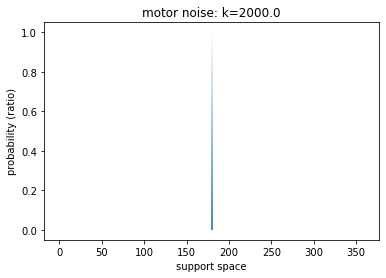

In [42]:
# plot prior
k_m = model.best_fit_p.tolist()[8]
plot_von_mises(support_space, k_m);
plt.title(f"motor noise: k={k_m}");
plt.ylabel("probability (ratio)");
plt.xlabel("support space");

Tutorial complete !